# Massively parallel ML assisted transition path sampling from equilibrium shooting points

## Notebook 1: Generate shooting points with umbrella sampling

This is the first of a series of example notebooks on massively parallel transition path sampling (TPS) using shooting points with a known equilibrium weight. Shooting from points with known equilibrium weight has the advantage that we can associate a weight with each generated transition, i.e. we can add all transitions from all parallel samplers into one set (instead of building as many Markov chains as we have samplers). As usual we will use capped alanine dipeptide as an example system and sample the transition between the $\alpha_R$ and $C7_{eq}$ states.

For a nice writeup of the theory see [Conditioning Normalizing Flows for Rare Event Sampling](https://arxiv.org/abs/2207.14530) (Sebastian Falkner, Alessandro Coretti, Salvatore Romano, Phillip Geissler and Christoph Dellago; arXiv 2022). However, unlinke Falkner et al, here we will not train a Boltzmann generator to get our ensemble of equillibrium points but we will use an umbrella sampling in the transition region. This has the benefit that it also work for larger systems until Boltzmann generators can handle large systems. It has the drawback that our ensemble of shooting points is not complete in the sense that we can not generate an infinite number of different configurations, but just the ones we sampled in the umbrella sampling (which should not be an issue in practice if the umbrella sampling is long enough).

Note that here we only use one (large) umbrella sampling window, this means we do not have to use (binless) WHAM to get the structure weights, instead we can just calculate them from the (known) bias potential. We could naturally also use multiple umbrella sampling windows and would then calculate the equilibrium weights for each structure (using binless WHAM) and use the resulting weights instead.

**This notebook should be run on a multi-core workstation preferably with a GPU**, otherwise you will have a very long coffee break and a very hot laptop.

**Required knowledge/recommended reading:** This notebooks assumes some familarity with the `asyncmd` (namely the [gromacs] engine and TrajectoryFunctionWrapper classes). Please see the example notebooks in `asyncmd` for an introduction.

In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt

import asyncmd

import aimmd
import aimmd.distributed as aimmdd

Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_slurm_settings()` with the appropriate arguments.
/home/think/.conda/envs/aimmd_dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Tensorflow/Keras not available


In [3]:
# set the directory to which we will write the simulation data
scratch_dir = "."

## Load a transition to pick the initial configuration from

In [4]:
# descriptor_func_psi_phi just returns the ψ and φ dihedrals for capped alanine dipeptide
from state_funcs_mda import descriptor_func_psi_phi

# we wrapp it with a `TrajectoryFunctionWrapper` to make it awaitable
wrapped_psi_phi = asyncmd.trajectory.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

In [5]:
# load a transition between the two states alpha_R and C7_eq
traj = asyncmd.Trajectory(structure_file="gmx_infiles/ala_300K_amber99sb-ildn.tpr",
                          trajectory_files="gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr")

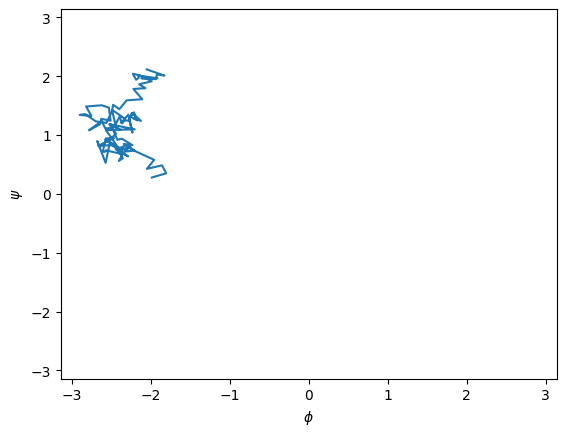

In [6]:
# plot the transition in the ψ, φ plane
fig, axs = plt.subplots()

psi_phi = await wrapped_psi_phi(traj)

axs.plot(psi_phi[:, 1], psi_phi[:, 0])
axs.set_ylabel("$\psi$")
axs.set_xlabel("$\phi$")
axs.set_xlim(-np.pi, np.pi)
axs.set_ylim(-np.pi, np.pi);

## Setup one umbrella sampling window on the top of the barrier

Below we will load the gromacs mdp file we also use for the TPS and modify it to add the pulling coordinates for the umbrella sampling. We will use a harmonic potential both in $\psi$ and $\phi$ direction. The potential in $\psi$ will keep the system on the top of the barrier (at around 80°) and the potential in $\phi$ is very soft and just to make sure we do not see any transitions to the negative $\phi$ region of the ramachandran plot.

Note that this works because we have already added the groups "psi_at1", "psi_at2", "psi_at3", "psi_at4", "phi_at1", "phi_at2", "phi_at3" and "phi_at4" to the index file (`index.ndx`) that you find in the folder `gmx_infiles`. To use different pulling coordinates you will have to define the respective pull-groups in the index file yourself.

In [7]:
# load the mdp file
mdconfig = asyncmd.gromacs.MDP("gmx_infiles/md.mdp")

In [8]:
# have a look at the mdp before modifying it
print(mdconfig)

<class 'asyncmd.gromacs.mdconfig.MDP'> has been changed since parsing: False
Current content:
----------------
title : ['test']
cpp : ['/lib/cpp']
include : ['-I../top']
define : []
integrator : md-vv
dt : 0.002
nsteps : -1
nstxout : 0
nstvout : 0
nstlog : 20
nstxout-compressed : 20
nstlist : 50
ns-type : grid
cutoff-scheme : Verlet
rlist : 1.1
coulombtype : PME
rcoulomb : 1.1
rvdw : 1.1
tcoupl : v-rescale
tc-grps : ['Protein', 'SOL']
tau-t : [0.5, 0.5]
ref-t : [300.0, 300.0]
Pcoupl : C-rescale
tau-p : 1.0
compressibility : [4.5e-05]
ref-p : [1.0]
gen-vel : no
gen-temp : 300.0
gen-seed : 173529
constraints : h-bonds



In [9]:
# now add the pulling/harmonic potentials
mdconfig["pull"] = "yes"
mdconfig["pull-nstxout"] = 1000
mdconfig["pull-nstfout"] = 1000
mdconfig["pull-ngroups"] = 8  # we have 4 atoms/groups per dihedral, i.e. 8 groups for two dihedrals
mdconfig["pull-ncoords"] = 2  # we build 2 pull coords from the 8 groups
# our 4 atoms defining the ψ dihedral
mdconfig["pull-group1-name"] = "psi_at1"
mdconfig["pull-group2-name"] = "psi_at2"
mdconfig["pull-group3-name"] = "psi_at3"
mdconfig["pull-group4-name"] = "psi_at4"
mdconfig["pull-coord1-type"] = "umbrella"  # make it a harmonic potential
mdconfig["pull-coord1-geometry"] = "dihedral"  # around the dihedral
mdconfig["pull-coord1-groups"] = ["1", "2", "2", "3", "3", "4"]  # defined by our 4 atoms
mdconfig["pull-coord1-init"] = "80"  # reference angle in degree
mdconfig["pull-coord1-k"] = "110"  # force constant in kJ/ (mol * rad**2)
# and also keep us in place in φ gently
# our 4 atoms defining the phi dihedral
mdconfig["pull-group5-name"] = "phi_at1"
mdconfig["pull-group6-name"] = "phi_at2"
mdconfig["pull-group7-name"] = "phi_at3"
mdconfig["pull-group8-name"] = "phi_at4"
mdconfig["pull-coord2-type"] = "umbrella"  # again make it a harmonic potential
mdconfig["pull-coord2-geometry"] = "dihedral"  # around the dihedral
mdconfig["pull-coord2-groups"] = ["5", "6", "6", "7", "7", "8"]  # defined by our 4 atoms
mdconfig["pull-coord2-init"] = "-115"  # reference angle in degree
mdconfig["pull-coord2-k"] = "5"  # force constant in kJ/ (mol * rad**2)

# also reduce our output frequency so we get more independent configurations (and a smaller trajectory)
mdconfig["nstxout-compressed"] = 1000
# and also reduce the logging frequency so our log file stays small 
mdconfig["nstlog"] = 2000

## Select the starting configuration closest to our window center in $\psi$

In [10]:
psi_vals = psi_phi[:, 0]

closest_idx = np.argmin((psi_vals - 80 * np.pi/180)**2)

print(f" psi, phi values for starting frame are {psi_phi[closest_idx]} at frame index {closest_idx}.")

 psi, phi values for starting frame are [ 1.38717069 -2.21372452] at frame index 75.


## Extract the frame and write it to the umbrella sampling folder


We will use an `asyncmd.trajectory.FrameExtractor` (see the `asyncmd` example notebooks if you want to know more about them).

In [11]:
wdir = os.path.join(scratch_dir, "UmbrellaSampling")

if not os.path.exists(wdir):
    os.makedirs(wdir)

# directly draw random velocities for the initial frame (so we can let "gen-vel"="no" in the mdp)
extractor = asyncmd.trajectory.convert.RandomVelocitiesFrameExtractor(T=mdconfig["ref-t"][0])
starting_conf = extractor.extract(outfile=os.path.join(wdir, "starting_frame.trr"),
                                  traj_in=traj,
                                  idx=closest_idx,
                                  overwrite=True,
                                  )

## Initialize the engine object and run the umbrella sampling

In [12]:
engine = asyncmd.gromacs.GmxEngine(mdconfig=mdconfig,
                                   gro_file="gmx_infiles/conf.gro",
                                   top_file="gmx_infiles/topol_amber99sbildn.top",
                                   ndx_file="gmx_infiles/index.ndx",
                                   output_traj_type="XTC",
                                   mdrun_extra_args="-ntomp 4", 
                                   )

In [13]:
# call grompp
await engine.prepare(starting_configuration=starting_conf, workdir=wdir, deffnm="US")

In [14]:
# and let it run for 1e7 integration steps
out_traj = await engine.run_steps(nsteps=1e7)

## Have a look at the trajectory and density of configurations in the $\phi$-$\psi$-plane

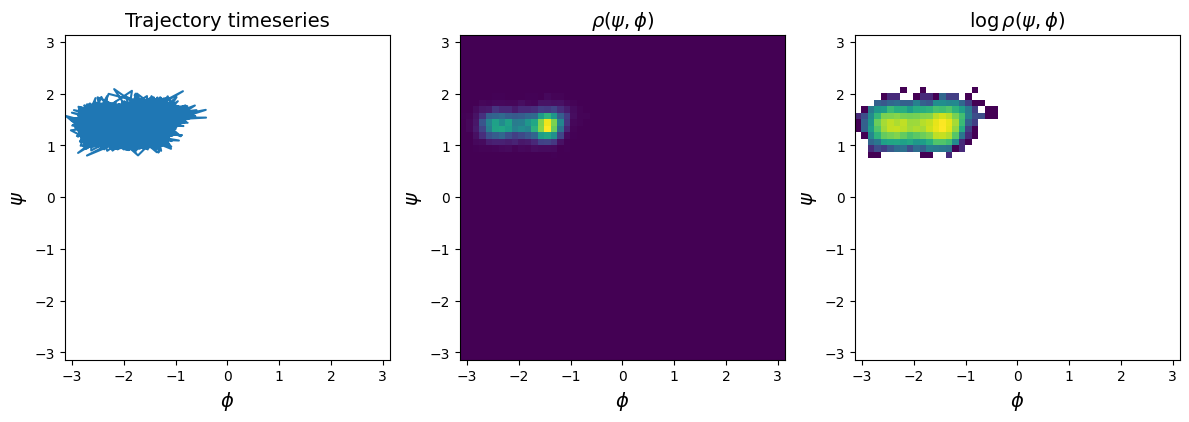

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(3*4, 4))

psi_phi = await wrapped_psi_phi(out_traj)

for i, ax in enumerate(axs):
    if i == 0:
        ax.plot(psi_phi[:, 1], psi_phi[:, 0], )
        ax.set_title("Trajectory timeseries", size=14)
    if i == 1:
        ax.hist2d(psi_phi[:, 1], psi_phi[:, 0], bins=50, range=[[-np.pi, np.pi], [-np.pi, np.pi]])
        ax.set_title("$\\rho(\psi, \phi)$", size=14)
    if i == 2:
        ax.hist2d(psi_phi[:, 1], psi_phi[:, 0], bins=50, range=[[-np.pi, np.pi], [-np.pi, np.pi]], norm="log")
        ax.set_title("$\\log \\rho(\psi, \phi)$", size=14)
    ax.set_ylabel("$\psi$", size=14)
    ax.set_xlabel("$\phi$", size=14)
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi);
    ax.set_aspect("equal");

fig.tight_layout()